In [1]:
import sys; sys.path.insert(0, '..')
from database.dataset import *

from general_utils.plots import plot_froc, plot_bootstrap_froc
from metrics.metrics import froc_curve, froc_curve_bootstrap, get_froc_df_of_img, get_froc_df_of_many_imgs_features

import matplotlib.pyplot as plt

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
from database.dataset import INBreast_Dataset
from mc_candidate_proposal.hough_mc import HoughCalcificationDetection
from metrics.metrics import circle_comparison, quick_circle_comparison
from general_utils.plots import plot_bboxes_over_image, simple_im_show2, simple_im_show
from pathlib import Path
from tqdm import tqdm
import cv2
from general_utils.utils import get_tp_fp_fn_center_patch_criteria, patch_coordinates_from_center

In [3]:
db = INBreast_Dataset(
    return_lesions_mask=True,
    level='image',
    max_lesion_diam_mm=None,
    partitions=['train', 'validation'],
    min_breast_fraction_roi=0.5,
    normalize=None,
    n_jobs=-1,
    use_muscle_mask=True
)

In [4]:
HOUGH1_PARAMS = {'method': cv2.HOUGH_GRADIENT, 'dp': 1, 'minDist': 14,
                 'param1': 300, 'param2': 5,  'minRadius': 2, 'maxRadius': 10}

hd = HoughCalcificationDetection(hough1_params=HOUGH1_PARAMS)


In [6]:
test_imgs = [ 48,  49,  69, 163,  95,  94,   0, 113,  36, 162,  48,  93, 131,
        98,  42, 112, 149, 127,   0, 138, 114,  43, 127,  23, 130, 121,
        98,  62, 163, 123,  82, 148,  50, 155,  14,  41,  58,  36,  10,
        86,  43, 104,  11,   2,  51,  80,  32, 128,  38,  19]

In [121]:
grid_search_res = {}
for p2 in tqdm([6, 8, 10, 12, 14, 16]):

    h1_res = []
    h2_res = []

    HOUGH1_PARAMS = {'method': cv2.HOUGH_GRADIENT, 'dp': 1, 'minDist': p2,
                    'param1': 300, 'param2': 5,  'minRadius': 2, 'maxRadius': 10}

    hd = HoughCalcificationDetection(hough1_params=HOUGH1_PARAMS)
    
    for idx in tqdm(test_imgs[:]):
        mask = db[idx]['lesion_mask']
        image = db[idx]['img']
        image_id = db.df.iloc[idx].img_id
        true_bboxes = db[idx]['lesion_bboxes']

        h1_circles, h2_circles = hd.detect(
            image, image_id, load_processed_images=True, hough2=False)

        
        TP, FP, FN = get_tp_fp_fn_center_patch_criteria(h1_circles, mask, None, 14, True)
        h1_res.append({'image_id':image_id, 'TP': len(TP), 'FP': len(FP), 'FN': len(FN)})
    
    h1_res_df = pd.DataFrame(h1_res).set_index('image_id')
    h1_res_df['sensitivity'] =  h1_res_df.TP/(h1_res_df.TP + h1_res_df.FN)
    grid_search_res[f'param2-{p2} maxRadius-{maxR}'] = h1_res_df

100%|██████████| 6/6 [03:46<00:00, 37.78s/it]


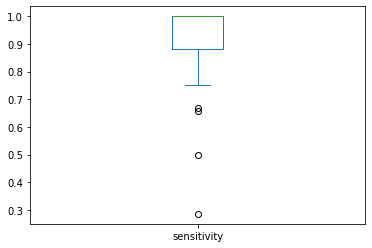

param2-6 maxRadius-20


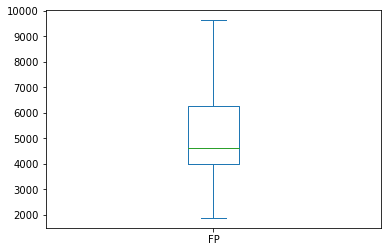

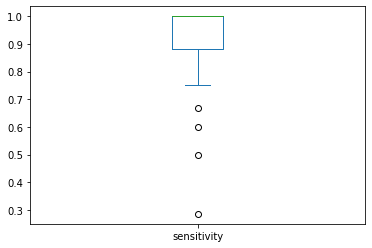

param2-8 maxRadius-20


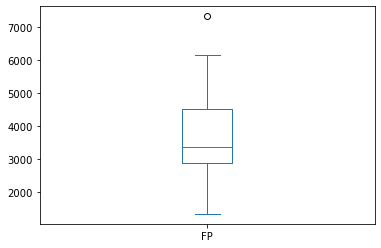

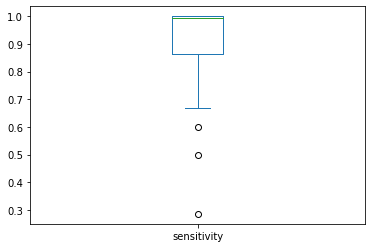

param2-10 maxRadius-20


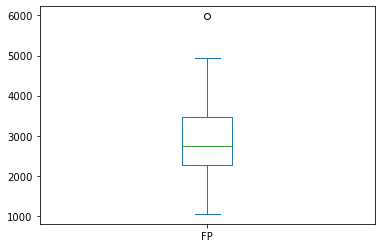

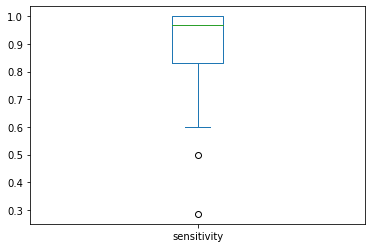

param2-12 maxRadius-20


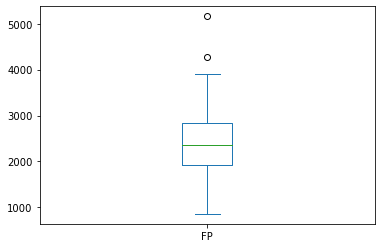

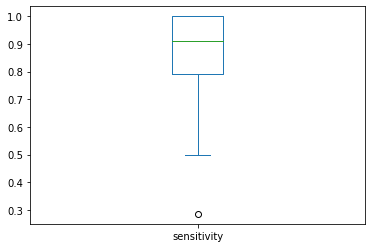

param2-14 maxRadius-20


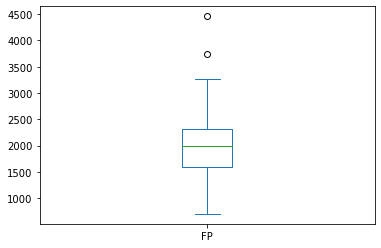

In [122]:
for k, v in grid_search_res.items():
    if v.sensitivity.median()>0.9:
        v.sensitivity.plot.box()
        plt.show()
        print(k)
        v.FP.plot.box()
        plt.show()

In [7]:

h1_res = []
h2_res = []

# HOUGH1_PARAMS = {'method': cv2.HOUGH_GRADIENT, 'dp': 1, 'minDist': 14,
#                 'param1': 300, 'param2': 5,  'minRadius': 2, 'maxRadius': 10}
# 0.8721082627089151 0.9097383720930232 mean med sens with FP med around 2k

HOUGH1_PARAMS = {'method': cv2.HOUGH_GRADIENT, 'dp': 1, 'minDist': 10,
                'param1': 300, 'param2': 5,  'minRadius': 2, 'maxRadius': 10}

HOUGH2_PARAMS = {'method': cv2.HOUGH_GRADIENT, 'dp': 1, 'minDist': 20,
                 'param1': 300, 'param2': 3,  'minRadius': 2, 'maxRadius': 10}


hd = HoughCalcificationDetection(hough1_params=HOUGH1_PARAMS,
                                 hough2_params=HOUGH2_PARAMS)

for idx in tqdm(test_imgs[:10]):
    mask = db[idx]['lesion_mask']
    image = db[idx]['img']
    image_id = db.df.iloc[idx].img_id
    true_bboxes = db[idx]['lesion_bboxes']

    h1_circles, h2_circles = hd.detect(
        image, image_id, load_processed_images=True, hough2=True)

    
    TP, FP, FN = get_tp_fp_fn_center_patch_criteria(h1_circles, mask, None, 14, True)
    h1_res.append({'image_id':image_id, 'TP': len(TP), 'FP': len(FP), 'FN': len(FN)})
    
    TP, FP, FN = get_tp_fp_fn_center_patch_criteria(h2_circles, mask, None, 14, True)
    h2_res.append({'image_id':image_id, 'TP': len(TP), 'FP': len(FP), 'FN': len(FN)})

h1_res_df = pd.DataFrame(h1_res).set_index('image_id')
h1_res_df['sensitivity'] =  h1_res_df.TP/(h1_res_df.TP + h1_res_df.FN)

h2_res_df = pd.DataFrame(h2_res).set_index('image_id')
h2_res_df['sensitivity'] =  h2_res_df.TP/(h2_res_df.TP + h2_res_df.FN)

100%|██████████| 10/10 [01:34<00:00,  9.50s/it]


0.8446886446886447 0.875


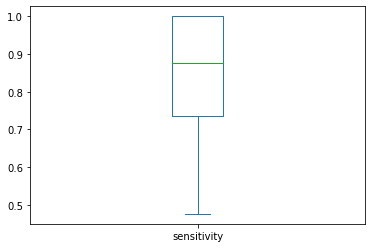

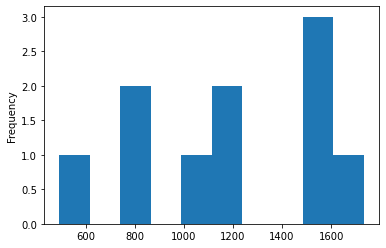

In [8]:
h2_res_df = pd.DataFrame(h2_res).set_index('image_id')
h2_res_df['sensitivity'] =  h2_res_df.TP/(h2_res_df.TP + h2_res_df.FN)
print(h2_res_df.sensitivity.mean(), h2_res_df.sensitivity.median())
h2_res_df.sensitivity.plot.box()
plt.show()
h2_res_df.FP.plot.hist()
plt.show()

0.9437912087912087 0.975


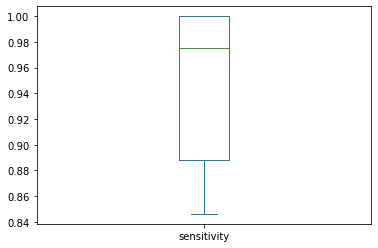

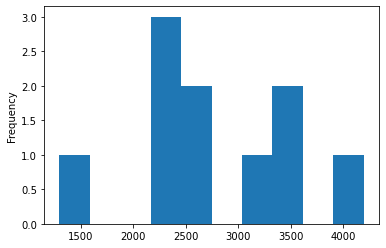

In [9]:
h1_res_df = pd.DataFrame(h1_res).set_index('image_id')
h1_res_df['sensitivity'] =  h1_res_df.TP/(h1_res_df.TP + h1_res_df.FN)
print(h1_res_df.sensitivity.mean(), h1_res_df.sensitivity.median())
h1_res_df.sensitivity.plot.box()
plt.show()
h1_res_df.FP.plot.hist()
plt.show()

<AxesSubplot:>

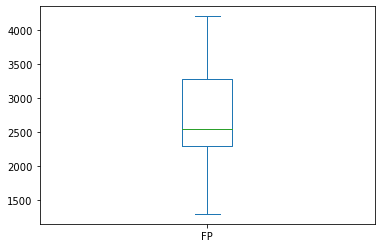

In [170]:
h1_res_df.FP.plot.box()

In [156]:
from scipy import spatial
from mc_candidate_proposal.morphology_mc import filter_by_distance

In [163]:
h2_circles.shape

(1240, 3)

In [215]:
min_distance = 6
# filter by distance
centers = h2_circles[:, :]
tree = spatial.cKDTree(centers[:, :-1])
pairs = tree.query_pairs(min_distance)

# indexes of candidates for which for closer than min_distance
# candidates only bigger one is kept
indxs = filter_by_distance(centers, pairs)

ValueError: cannot compute fingerprint of empty set

In [214]:
len(indxs) - len(h1_circles)

-44

In [210]:
cv2.imwrite('ttt.png', 
            plot_bboxes_over_image(image,
                                   [true_bboxes, h2_circles],
                                   [(0, 255, 0), (0, 0, 255)], 
                                   ['rect', 'circ']))

True

In [211]:
cv2.imwrite('ttt2.png', 
            plot_bboxes_over_image(image,
                                   [true_bboxes, h2_circles[indxs]],
                                   [(0, 255, 0), (0, 0, 255)], 
                                   ['rect', 'circ']))

True